In [1]:
# ### Cell 1: Imports ###
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from pathlib import Path
# from torch.cuda.amp import autocast, GradScaler
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# ### Cell 2: Load and Preprocess Data ###
# # UPDATED FOR 3D: Added 'z' to input and 'Uz' to output
# df = pd.read_csv('/kaggle/input/2d-trapezium/concatenated_data_all_steps.csv')
# df_subset = df.groupby('time', group_keys=False).head(1500)
# print(f"Original shape: {df.shape}")
# print(f"Subset shape: {df_subset.shape}")

# # Optional — check how many unique time steps and how many samples per step
# print(f"Unique time steps: {df_subset['time'].nunique()}")
# print(df_subset['time'].value_counts().head())

# X = df_subset[['x', 'y']].values
# Y = df_subset[['Ux', 'Uy', 'p']].values

# X_all = df[['time', 'x', 'y']].values
# Y_all = df[['Ux', 'Uy', 'p']].values

# y_scaler = StandardScaler()
# Y_scaled = y_scaler.fit_transform(Y)
# Y_scaled_all = y_scaler.transform(Y_all)

# x_train_tensor = torch.tensor(X, dtype=torch.float32)
# y_train_tensor = torch.tensor(Y_scaled, dtype=torch.float32)
# y_all_tensor = torch.tensor(Y_scaled_all,dtype=torch.float32)

# print(f"Input shape: {x_train_tensor.shape}")
# print(f"Output shape: {y_train_tensor.shape}")

In [3]:
# ### Cell 5: Define PDE Loss (Unsteady Laminar 2D Navier-Stokes) ###
# nu = 1e-05

# def pde_loss(x, y, pred):
#     # u(x,y,t), v(x,y,t), p(x,y,t)
#     u, v, p = pred[:, 0:1], pred[:, 1:2], pred[:, 2:3]

#     # First derivatives
#     u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
#     u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
#     u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
#     v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
#     v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
#     v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]

#     p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
#     p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

#     # Second derivatives (Laplacian)
#     u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
#     u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    
#     v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
#     v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

#     # Continuity equation (2D)
#     cont = u_x + v_y

#     # Momentum equations
#     # x-momentum
#     f = u_t + (u * u_x + v * u_y) + p_x - nu * (u_xx + u_yy)

#     # y-momentum
#     g = v_t + (u * v_x + v * v_y) + p_y - nu * (v_xx + v_yy)

#     # Losses
#     f_loss = (f ** 2).mean()
#     g_loss = (g ** 2).mean()
#     cont_loss = (cont ** 2).mean()
    
#     return f_loss + g_loss + cont_loss

In [4]:
# ## Cell 6: Define the Model (PirateNet) ###
# # This class definition is generic and does not need changes
# # The input_dim and output_dim are set during instantiation
# class PirateNetBlock(nn.Module):
#     def __init__(self, hidden_dim):
#         super(PirateNetBlock, self).__init__()
#         self.dense1 = nn.Linear(hidden_dim, hidden_dim)
#         self.dense2 = nn.Linear(hidden_dim, hidden_dim)
#         self.dense3 = nn.Linear(hidden_dim, hidden_dim)
#         self.alpha = nn.Parameter(torch.zeros(1))

#     def forward(self, x, u, v):
#         f = F.tanh(self.dense1(x))
#         z1 = f * u + (1 - f) * v
#         g = F.tanh(self.dense2(z1))
#         z2 = g * u + (1 - g) * v
#         h = F.tanh(self.dense3(z2))
#         return self.alpha * h + (1 - self.alpha) * x

# class PirateNet(nn.Module):
#     def __init__(
#         self,
#         input_dim,
#         output_dim,
#         num_blocks,
#         hidden_dim=256,
#         s=1.0,
#         activation=F.tanh,
#     ):
#         super(PirateNet, self).__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.num_blocks = num_blocks
#         self.hidden_dim = hidden_dim
#         self.s = s
#         self.activation = activation
#         self.B = nn.Parameter(torch.randn(input_dim, hidden_dim // 2) * s)
#         self.embedding = lambda x: torch.cat(
#             [torch.cos(torch.matmul(x, self.B)), torch.sin(torch.matmul(x, self.B))],
#             dim=-1,
#         )
#         self.blocks = nn.ModuleList(
#             [PirateNetBlock(hidden_dim) for _ in range(num_blocks)]
#         )
#         self.U = nn.Linear(hidden_dim, hidden_dim)
#         self.V = nn.Linear(hidden_dim, hidden_dim)
#         self.final_layer = nn.Linear(hidden_dim, output_dim, bias=False)
#         print(f"Final layer weights shape: {self.final_layer.weight.data.shape}")
#         self.initialize_weights()

#     def initialize_weights(self):
#         for module in self.modules():
#             if isinstance(module, nn.Linear):
#                 torch.nn.init.xavier_uniform_(module.weight)
#                 if module.bias is not None:
#                     module.bias.data.zero_()

#     def forward(self, x):
#         x = self.embedding(x)
#         u = self.activation(self.U(x))
#         v = self.activation(self.V(x))
#         for block in self.blocks:
#             x = block(x, u, v)
#         return self.final_layer(x)

In [5]:
# scaler = GradScaler()

# def train_model(model, optimizer, iterations, x_train, y_train, val_x, val_y):
#     logs = {
#         "iteration": [],
#         "loss_from_pde": [],
#         "loss_from_data": [],
#         "total_loss": [],
#         "val_loss": [],
#     }
#     best_val_loss = float('inf')
#     patience = 50
#     patience_counter = 0

#     def closure():
#         nonlocal best_val_loss, patience_counter
#         optimizer.zero_grad()

#         # Split input into individual tensors
#         t, x, y, z = x_train[:, 0:1], x_train[:, 1:2], x_train[:, 2:3], x_train[:, 3:4]
#         t.requires_grad_(True)
#         x.requires_grad_(True)
#         y.requires_grad_(True)
#         z.requires_grad_(True)
#         input_tensor = torch.cat([t, x, y, z], dim=1)

#         # Forward pass under autocast (mixed precision)
#         with autocast():
#             pred = model(input_tensor)
#             loss_from_data = F.mse_loss(pred, y_train)

#         # PDE loss in full precision (for gradient stability)
#         loss_from_pde = pde_loss(t, x, y, z, pred.float())

#         # Combine losses
#         loss = loss_from_data + loss_from_pde

#         # Backward with gradient scaling
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()

#         # Validation step
#         model.eval()
#         with torch.no_grad():
#             val_pred = model(val_x)
#             val_loss = F.mse_loss(val_pred, val_y)
#         model.train()

#         # Logging
#         closure.iteration += 1
#         logs["iteration"].append(closure.iteration)
#         logs["loss_from_pde"].append(loss_from_pde.item())
#         logs["loss_from_data"].append(loss_from_data.item())
#         logs["total_loss"].append(loss.item())
#         logs["val_loss"].append(val_loss.item())

#         # Print progress
#         if closure.iteration % 100 == 0:
#             print(
#                 f"Iter {closure.iteration:04d}: PDE={loss_from_pde.item():.3f}, "
#                 f"Data={loss_from_data.item():.3f}, Val={val_loss.item():.3f}"
#             )

#         # Early stopping
#         if val_loss.item() < best_val_loss:
#             best_val_loss = val_loss.item()
#             patience_counter = 0
#             torch.save(model.state_dict(), 'best_model_adam.pth')
#         else:
#             patience_counter += 1

#         if patience_counter >= patience:
#             print(f"Early stopping at iteration {closure.iteration}")
#             raise KeyboardInterrupt

#         return loss

#     closure.iteration = 0

#     try:
#         for iteration in range(iterations):
#             _ = closure()
#     except KeyboardInterrupt:
#         print("Training stopped early or manually.")

#     model.load_state_dict(torch.load('best_model_adam.pth'))
#     return logs


# ### Cell 8: Setup Training ###
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# torch.manual_seed(42)
# indices = torch.randperm(x_train_tensor.size(0))
# train_size = int(0.8 * x_train_tensor.size(0))

# x_train = x_train_tensor[indices[:train_size]].to(device)
# y_train = y_train_tensor[indices[:train_size]].to(device)
# x_val = x_train_tensor[indices[train_size:]].to(device)
# y_val = y_train_tensor[indices[train_size:]].to(device)

# model = PirateNet(
#     input_dim=4,   # (t, x, y, z)
#     output_dim=4,  # (Ux, Uy, Uz, p)
#     num_blocks=8,
#     hidden_dim=256,
# ).to(device)


# ### Cell 9: Train with Adam ###
# lr = 0.001
# iterations = 3000
# optimizer_adam = optim.Adam(model.parameters(), lr=lr)

# logs_adam = train_model(model, optimizer_adam, iterations, x_train, y_train, x_val, y_val)

In [6]:
# def train_pinn_with_curriculum(model, optimizer, iterations, x_train, y_train, val_x, val_y, pde_loss_fn):
#     """
#     Trains a PINN with curriculum weighting on the PDE loss.
#     λ starts small and grows during training to balance data fitting and physics consistency.
#     """

#     logs = {
#         "iteration": [], 
#         "data_loss": [], 
#         "pde_loss": [], 
#         "total_loss": [], 
#         "val_loss": []
#     }

#     best_val_loss = float('inf')
#     patience = 500
#     patience_counter = 0

#     # Curriculum parameters
#     λ_start = 1e-4
#     λ_end = 1.0
#     λ_growth = (λ_end / λ_start) ** (1 / iterations)  # geometric growth rate
#     λ = λ_start

#     for iteration in range(1, iterations + 1):
#         model.train()
#         optimizer.zero_grad()

#         # Split inputs (t, x, y, z)
#         t, x, y = (
#             x_train[:, 0:1],
#             x_train[:, 1:2],
#             x_train[:, 2:3],
#         )
#         t.requires_grad_(True)
#         x.requires_grad_(True)
#         y.requires_grad_(True)

#         # Forward pass
#         pred = model(torch.cat([t, x, y], dim=1))

#         # Compute losses
#         data_loss = F.mse_loss(pred, y_train)
#         pde_loss = pde_loss_fn(t, x, y, pred)
#         total_loss = data_loss + λ * pde_loss

#         total_loss.backward()
#         optimizer.step()

#         # Validation
#         model.eval()
#         with torch.no_grad():
#             val_pred = model(val_x)
#             val_loss = F.mse_loss(val_pred, val_y)

#         # Log values
#         logs["iteration"].append(iteration)
#         logs["data_loss"].append(data_loss.item())
#         logs["pde_loss"].append(pde_loss.item())
#         logs["total_loss"].append(total_loss.item())
#         logs["val_loss"].append(val_loss.item())

#         if iteration % 100 == 0 or iteration == 1:
#             print(
#                 f"Iter {iteration:4d} | λ={λ:.6f} | "
#                 f"Data Loss={data_loss.item():.4e}, PDE Loss={pde_loss.item():.4e}, "
#                 f"Val Loss={val_loss.item():.4e}"
#             )

#         # Early stopping logic
#         if val_loss.item() < best_val_loss:
#             best_val_loss = val_loss.item()
#             patience_counter = 0
#             torch.save(model.state_dict(), "best_pinn_model_curriculum.pth")
#         else:
#             patience_counter += 1

#         if patience_counter >= patience:
#             print(f"Early stopping at iteration {iteration}")
#             break

#         # Update λ (grow gradually)
#         λ *= λ_growth
#         λ = min(λ, λ_end)  # clamp to max

#     # Load best model
#     model.load_state_dict(torch.load("best_pinn_model_curriculum.pth"))
#     print("✅ Best model loaded from checkpoint.")
#     return logs

In [7]:
# import matplotlib.pyplot as plt

# def plot_training_logs(logs, title="ANN Training Progress"):
#     """
#     Plots training and validation loss curves from the logs dictionary.
#     Args:
#         logs: dict with keys ['iteration', 'train_loss', 'val_loss']
#         title: plot title
#     """
#     plt.figure(figsize=(8, 5))
#     plt.plot(logs["iteration"], logs["data_loss"], label="MSE Loss", linewidth=2)
#     plt.plot(logs["iteration"], logs["pde_loss"], label="PDE Loss", linewidth=2)
#     plt.plot(logs["iteration"], logs["total_loss"], label="Total Loss", linewidth=2)
#     plt.plot(logs["iteration"], logs["val_loss"], label="Validation Loss", linewidth=2)
#     plt.xlabel("Iteration", fontsize=12)
#     plt.ylabel("MSE Loss", fontsize=12)
#     plt.title(title, fontsize=14)
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.show()


In [8]:

# # UPDATED FOR 3D: Input dim is 4 (t, x, y, z)
# input_dim = 3
# # UPDATED FOR 3D: Output dim is 4 (u, v, w, p)
# output_dim = 3
# n_layers = 8
# layer_dim = 256

# ### Cell 8: Setup Training ###
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# torch.manual_seed(42)
# indices = torch.randperm(x_train_tensor.size(0))
# train_size = int(0.8 * x_train_tensor.size(0))

# x_train = x_train_tensor[indices[:train_size]].to(device)
# y_train = y_train_tensor[indices[:train_size]].to(device)
# x_val = x_train_tensor[indices[train_size:]].to(device)
# y_val = y_train_tensor[indices[train_size:]].to(device)

# model = PirateNet(
#     input_dim=input_dim,
#     output_dim=output_dim,
#     hidden_dim=layer_dim,
#     num_blocks=1
#     # num_layers=n_layers
# ).to(device)

# lr = 0.001
# iterations = 3000 
# optimizer_adam = optim.Adam(model.parameters(), lr=lr)
# logs_adam = train_pinn_with_curriculum(model, optimizer_adam, iterations, x_train, y_train, x_val, y_val,pde_loss_fn=pde_loss)

In [9]:
# plot_training_logs(logs_adam, title="2D PINN Training and Validation Loss")

In [10]:
# ### Cell 15: Calculate L2 Error on Training Data ###
# model.eval()
# with torch.no_grad():
#     # Predict on the full dataset
#     x_all_tensor = torch.tensor(X_all, dtype=torch.float32).to(device)
#     y_pred_scaled = model(x_all_tensor)

# # Convert predictions and ground truth back to original scale
# y_pred_orig = y_scaler.inverse_transform(y_pred_scaled.cpu().numpy())
# y_true_orig = y_scaler.inverse_transform(y_all_tensor.cpu().numpy())



# # ---- Compute metrics per component ----
# mae = np.mean(np.abs(y_pred_orig - y_true_orig), axis=0)
# mse = np.mean((y_pred_orig - y_true_orig) ** 2, axis=0)
# l2 = np.linalg.norm(y_pred_orig - y_true_orig, axis=0) / np.linalg.norm(y_true_orig, axis=0)





# # ---- Print results ----
# components = ['U_x', 'U_y', 'p']
# print("\n=== Full-Dataset Evaluation ===")
# for i, comp in enumerate(components):
#     print(f"{comp}: MAE = {mae[i]:.4f}, MSE = {mse[i]:.4f}, L2 = {l2[i]:.4f}")





# # ---- Optional: Velocity magnitude evaluation ----
# vel_pred = np.sqrt(np.sum(y_pred_orig[:, :3] ** 2, axis=1))
# vel_true = np.sqrt(np.sum(y_true_orig[:, :3] ** 2, axis=1))

# mae_vel = np.mean(np.abs(vel_pred - vel_true))
# mse_vel = np.mean((vel_pred - vel_true) ** 2)
# l2_vel = np.linalg.norm(vel_pred - vel_true) / np.linalg.norm(vel_true)

# print(f"\nVelocity Magnitude: MAE = {mae_vel:.4f}, MSE = {mse_vel:.4f}, L2 = {l2_vel:.4f}")

# Attempt 2

Loaded data: (20200, 7) Subset: (20200, 7)
Iter     1 | λ=0.010000 | data=1.22286 pde=10.49875 val=1.18895
Iter    50 | λ=0.011194 | data=0.14505 pde=1.02874 val=0.15166
Iter   100 | λ=0.012560 | data=0.09684 pde=0.68015 val=0.10024
Iter   150 | λ=0.014093 | data=0.08167 pde=0.58212 val=0.08550
Iter   200 | λ=0.015812 | data=0.07591 pde=0.44238 val=0.08189
Iter   250 | λ=0.017742 | data=0.06993 pde=0.37089 val=0.07810
Iter   300 | λ=0.019907 | data=0.07288 pde=0.81503 val=0.07883
Iter   350 | λ=0.022336 | data=0.06183 pde=0.38999 val=0.07154
Iter   400 | λ=0.025061 | data=0.08936 pde=1.87891 val=0.09785
Iter   450 | λ=0.028119 | data=0.06590 pde=0.13069 val=0.07610
Iter   500 | λ=0.031550 | data=0.06118 pde=0.20729 val=0.07154
Iter   550 | λ=0.035400 | data=0.06320 pde=0.08332 val=0.07042
Iter   600 | λ=0.039719 | data=0.06207 pde=0.10973 val=0.07134
Iter   650 | λ=0.044566 | data=0.05933 pde=0.70220 val=0.06994
Iter   700 | λ=0.050003 | data=0.07271 pde=0.49047 val=0.08144
Iter   750 

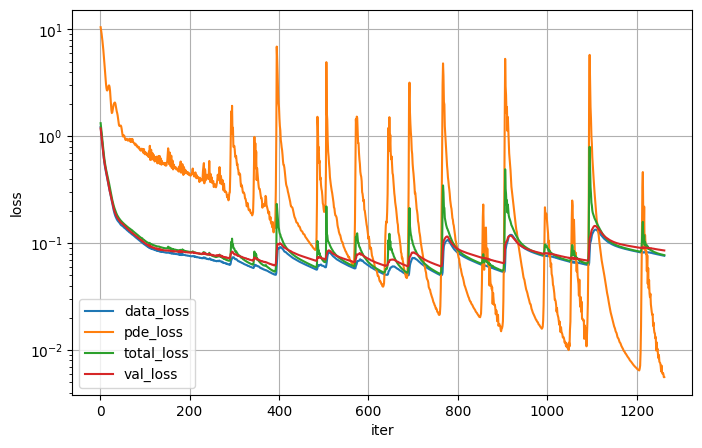

Saved predictions to pinn_rans2d_predictions.csv
Viscous stress sample shapes: torch.Size([200, 1]) torch.Size([200, 1])


In [11]:
# Full 2D unsteady RANS PINN pipeline (PyTorch)
# Outputs: u, v, p, uu, uv, vv
# PDE residuals include ∂x(uu) + ∂y(uv) etc (Reynolds stress divergence)
# Make sure torch, pandas, numpy, sklearn, matplotlib are installed.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# -----------------------
# PirateNet (unchanged structure, small API adapt)
# -----------------------
class PirateNetBlock(nn.Module):
    def __init__(self, hidden_dim):
        super(PirateNetBlock, self).__init__()
        self.dense1 = nn.Linear(hidden_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, hidden_dim)
        self.dense3 = nn.Linear(hidden_dim, hidden_dim)
        self.alpha = nn.Parameter(torch.zeros(1))

    def forward(self, x, u, v):
        f = torch.tanh(self.dense1(x))
        z1 = f * u + (1 - f) * v
        g = torch.tanh(self.dense2(z1))
        z2 = g * u + (1 - g) * v
        h = torch.tanh(self.dense3(z2))
        return self.alpha * h + (1 - self.alpha) * x

class PirateNet(nn.Module):
    def __init__(self, input_dim, output_dim, num_blocks, hidden_dim=256, s=1.0):
        super(PirateNet, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.s = s
        # Random Fourier features embedding
        self.B = nn.Parameter(torch.randn(input_dim, hidden_dim // 2) * s)
        self.embedding = lambda x: torch.cat(
            [torch.cos(torch.matmul(x, self.B)), torch.sin(torch.matmul(x, self.B))],
            dim=-1,
        )
        self.blocks = nn.ModuleList([PirateNetBlock(hidden_dim) for _ in range(num_blocks)])
        self.U = nn.Linear(hidden_dim, hidden_dim)
        self.V = nn.Linear(hidden_dim, hidden_dim)
        self.final_layer = nn.Linear(hidden_dim, output_dim, bias=False)
        self.initialize_weights()

    def initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()

    def forward(self, x):
        # x: (N, input_dim)
        x = self.embedding(x)
        u = torch.tanh(self.U(x))
        v = torch.tanh(self.V(x))
        for block in self.blocks:
            x = block(x, u, v)
        return self.final_layer(x)

# -----------------------
# PDE loss: 2D unsteady RANS-style (u,v,p,uu,uv,vv)
# -----------------------
# nu = kinematic viscosity
nu = 1e-5  # set from your config

def pde_loss_rans_2d(coords, pred):
    """
    coords: tensor (N,3) -> [t, x, y] requires_grad=True
    pred: tensor (N,6) -> [u, v, p, uu, uv, vv]
    """
    t = coords[:, 0:1]
    x = coords[:, 1:2]
    y = coords[:, 2:3]

    u = pred[:, 0:1]
    v = pred[:, 1:2]
    p = pred[:, 2:3]
    uu = pred[:, 3:4]   # <u'u'>
    uv = pred[:, 4:5]   # <u'v'>
    vv = pred[:, 5:6]   # <v'v'>

    # --- First derivatives (using autograd onto coords) ---
    # Stack grads efficiently by taking grad of each scalar output wrt coords.
    # For each variable we call autograd.grad(var, coords, ...) which returns (N,3)
    ones_u = torch.ones_like(u)
    ones_v = torch.ones_like(v)
    ones_p = torch.ones_like(p)
    ones_uu = torch.ones_like(uu)
    ones_uv = torch.ones_like(uv)
    ones_vv = torch.ones_like(vv)

    u_grads = torch.autograd.grad(u, coords, grad_outputs=ones_u, create_graph=True)[0]
    v_grads = torch.autograd.grad(v, coords, grad_outputs=ones_v, create_graph=True)[0]
    p_grads = torch.autograd.grad(p, coords, grad_outputs=ones_p, create_graph=True)[0]

    # components
    u_t = u_grads[:, 0:1]; u_x = u_grads[:, 1:2]; u_y = u_grads[:, 2:3]
    v_t = v_grads[:, 0:1]; v_x = v_grads[:, 1:2]; v_y = v_grads[:, 2:3]
    p_x = p_grads[:, 1:2]; p_y = p_grads[:, 2:3]  # p_t typically not needed

    # second derivatives (laplacians)
    u_xx = torch.autograd.grad(u_x, coords, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 1:2]
    u_yy = torch.autograd.grad(u_y, coords, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 2:3]
    v_xx = torch.autograd.grad(v_x, coords, grad_outputs=torch.ones_like(v_x), create_graph=True)[0][:, 1:2]
    v_yy = torch.autograd.grad(v_y, coords, grad_outputs=torch.ones_like(v_y), create_graph=True)[0][:, 2:3]

    # Reynolds stresses derivatives
    uu_grads = torch.autograd.grad(uu, coords, grad_outputs=ones_uu, create_graph=True)[0]
    uv_grads = torch.autograd.grad(uv, coords, grad_outputs=ones_uv, create_graph=True)[0]
    vv_grads = torch.autograd.grad(vv, coords, grad_outputs=ones_vv, create_graph=True)[0]

    uu_x = uu_grads[:, 1:2]
    uv_x = uv_grads[:, 1:2]
    uv_y = uv_grads[:, 2:3]
    vv_y = vv_grads[:, 2:3]

    # PDE residuals: unsteady RANS in 2D (x- and y-momentum)
    # x-momentum residual
    f = u_t + (u * u_x + v * u_y) + p_x - nu * (u_xx + u_yy) + uu_x + uv_y
    # y-momentum residual
    g = v_t + (u * v_x + v * v_y) + p_y - nu * (v_xx + v_yy) + uv_x + vv_y

    # continuity (incompressibility)
    cont = u_x + v_y

    f_loss = (f ** 2).mean()
    g_loss = (g ** 2).mean()
    cont_loss = (cont ** 2).mean()

    return f_loss + g_loss + cont_loss

# -----------------------
# Optional helper: viscous stress compute (Newtonian) for diagnostics
# -----------------------
def compute_viscous_stress(pred, coords, mu=1e-5):
    # pred: [u,v,...], coords: [t,x,y]
    u = pred[:, 0:1]; v = pred[:, 1:2]
    u_grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    v_grads = torch.autograd.grad(v, coords, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    u_x = u_grads[:, 1:2]; u_y = u_grads[:, 2:3]
    v_x = v_grads[:, 1:2]; v_y = v_grads[:, 2:3]
    tau_xx = 2 * mu * u_x
    tau_yy = 2 * mu * v_y
    tau_xy = mu * (u_y + v_x)
    return tau_xx, tau_yy, tau_xy

# -----------------------
# Data loading / preprocessing (adapt to your CSV)
# -----------------------
# Example: CSV contains columns ['time','x','y','Ux','Uy','p'].
DATA_PATH = '/kaggle/input/2d-trapezium/concatenated_data_all_steps.csv'  # update as needed
df = pd.read_csv(DATA_PATH)
# optionally reduce points (you used groupby head earlier)
df_subset = df.groupby('time', group_keys=False).head(1500)
print("Loaded data:", df.shape, "Subset:", df_subset.shape)

# features and targets
coords_np = df_subset[['time', 'x', 'y']].values.astype(np.float32)
Y_np = df_subset[['Ux', 'Uy', 'p']].values.astype(np.float32)

# We'll predict Reynolds stresses too; if you have true values use them, else initialize to zeros for supervised part
# If dataset doesn't contain true uu/uv/vv, we will train stresses purely from PDE (unsupervised).
has_reynolds_in_data = False
if has_reynolds_in_data:
    R_np = df_subset[['uu','uv','vv']].values.astype(np.float32)
    Y_full = np.concatenate([Y_np, R_np], axis=1)
else:
    # create dummy (zeros) supervised targets for stresses (we won't weigh them strongly)
    zeros_R = np.zeros((Y_np.shape[0], 3), dtype=np.float32)
    Y_full = np.concatenate([Y_np, zeros_R], axis=1)

# scale Y (u,v,p,uu,uv,vv)
y_scaler = StandardScaler()
Y_scaled = y_scaler.fit_transform(Y_full)

# convert to tensors
coords_tensor = torch.tensor(coords_np, dtype=torch.float32)
y_tensor = torch.tensor(Y_scaled, dtype=torch.float32)

# helper: create collocation subset (random sampling)
def get_collocation(coords, targets, n_points=5000, seed=42):
    rng = np.random.default_rng(seed)
    indices = rng.choice(coords.shape[0], size=min(n_points, coords.shape[0]), replace=False)
    return coords[indices, :], targets[indices, :]

# get collocation training set
N_collocation = 3000
coords_coll_np, y_coll_np = get_collocation(coords_np, Y_scaled, n_points=N_collocation)
coords_coll = torch.tensor(coords_coll_np, dtype=torch.float32)
y_coll = torch.tensor(y_coll_np, dtype=torch.float32)

# split train/val for supervised part (we use collocation for PDE and a small supervised set)
idx = np.arange(coords_coll.shape[0])
np.random.shuffle(idx)
train_ratio = 0.8
n_train = int(train_ratio * len(idx))
train_idx = idx[:n_train]
val_idx = idx[n_train:]

coords_train = coords_coll[train_idx].to(torch.float32)
y_train = y_coll[train_idx].to(torch.float32)
coords_val = coords_coll[val_idx].to(torch.float32)
y_val = y_coll[val_idx].to(torch.float32)

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
coords_train = coords_train.to(device)
y_train = y_train.to(device)
coords_val = coords_val.to(device)
y_val = y_val.to(device)

# -----------------------
# Training utilities: curriculum for PDE weight λ
# -----------------------
def train_pinn(model, optimizer, iterations, coords_train, y_train, coords_val, y_val,
               pde_loss_fn, lambda_start=1e-4, lambda_end=1.0):
    logs = {"iter": [], "data_loss": [], "pde_loss": [], "total_loss": [], "val_loss": []}
    best_val = float('inf')
    patience = 500
    patience_counter = 0

    # geometric growth for lambda
    lambda_growth = (lambda_end / lambda_start) ** (1.0 / max(iterations,1))
    lam = lambda_start

    model.train()
    for it in range(1, iterations + 1):
        optimizer.zero_grad()

        # coordinates for autograd must require grad (for PDE)
        coords = coords_train.clone().detach().requires_grad_(True).to(device)  # (N,3)
        pred = model(coords)  # (N,6)

        # supervised data loss (MSE on scaled targets)
        data_loss = F.mse_loss(pred, y_train)

        # PDE loss uses coords (with gradients) and predictions
        pde_loss_val = pde_loss_fn(coords, pred)

        total_loss = data_loss + lam * pde_loss_val
        total_loss.backward()
        optimizer.step()

        # validation (supervised only)
        model.eval()
        with torch.no_grad():
            coords_v = coords_val.to(device)
            pred_val = model(coords_v)
            val_loss = F.mse_loss(pred_val, y_val)
        model.train()

        # logging
        logs["iter"].append(it)
        logs["data_loss"].append(data_loss.item())
        logs["pde_loss"].append(pde_loss_val.item())
        logs["total_loss"].append(total_loss.item())
        logs["val_loss"].append(val_loss.item())

        if it % 50 == 0 or it == 1:
            print(f"Iter {it:5d} | λ={lam:.6f} | data={data_loss.item():.5f} pde={pde_loss_val.item():.5f} val={val_loss.item():.5f}")

        # checkpoint best
        if val_loss.item() < best_val:
            best_val = val_loss.item()
            patience_counter = 0
            torch.save(model.state_dict(), "best_pinn_rans2d.pth")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at iter {it}")
            break

        # update lambda
        lam *= lambda_growth
        lam = min(lam, lambda_end)

    # load best
    model.load_state_dict(torch.load("best_pinn_rans2d.pth"))
    print("Loaded best model (by val loss).")
    return logs

# -----------------------
# Instantiate model & train
# -----------------------
input_dim = 3   # [t, x, y]
output_dim = 6  # [u, v, p, uu, uv, vv]
model = PirateNet(input_dim=input_dim, output_dim=output_dim, num_blocks=4, hidden_dim=256).to(device)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

iterations = 2000
logs = train_pinn(model, optimizer, iterations, coords_train.to(device), y_train.to(device),
                  coords_val.to(device), y_val.to(device),
                  pde_loss_fn=pde_loss_rans_2d, lambda_start=1e-2, lambda_end=1.0)

# -----------------------
# Plot training logs
# -----------------------
plt.figure(figsize=(8,5))
plt.plot(logs['iter'], logs['data_loss'], label='data_loss')
plt.plot(logs['iter'], logs['pde_loss'], label='pde_loss')
plt.plot(logs['iter'], logs['total_loss'], label='total_loss')
plt.plot(logs['iter'], logs['val_loss'], label='val_loss')
plt.yscale('log')
plt.xlabel('iter'); plt.ylabel('loss'); plt.legend(); plt.grid(True);
plt.show()

# -----------------------
# Inference: predict on full dataset and inverse-transform outputs
# -----------------------
model.eval()
with torch.no_grad():
    coords_all = torch.tensor(coords_np, dtype=torch.float32).to(device)
    pred_all = model(coords_all).cpu().numpy()
    pred_all_unscaled = y_scaler.inverse_transform(pred_all)  # (N,6)

# Extract predictions
u_pred = pred_all_unscaled[:, 0]
v_pred = pred_all_unscaled[:, 1]
p_pred = pred_all_unscaled[:, 2]
uu_pred = pred_all_unscaled[:, 3]
uv_pred = pred_all_unscaled[:, 4]
vv_pred = pred_all_unscaled[:, 5]

# Save to CSV for inspection
out_df = pd.DataFrame({
    'time': coords_np[:,0],
    'x': coords_np[:,1],
    'y': coords_np[:,2],
    'u_pred': u_pred, 'v_pred': v_pred, 'p_pred': p_pred,
    'uu_pred': uu_pred, 'uv_pred': uv_pred, 'vv_pred': vv_pred
})
out_df.to_csv('pinn_rans2d_predictions.csv', index=False)
print("Saved predictions to pinn_rans2d_predictions.csv")

# -----------------------
# Example: compute viscous stress at sample collocation points
# -----------------------
coords_sample = coords_train[:200].clone().detach().requires_grad_(True).to(device)
pred_sample = model(coords_sample)
tau_xx, tau_yy, tau_xy = compute_viscous_stress(pred_sample, coords_sample, mu=nu)
print("Viscous stress sample shapes:", tau_xx.shape, tau_xy.shape)


In [12]:
### Cell 15: Calculate L2 / MAE / MSE Error on Full Dataset ###

# --- FIX 1: create full coords and outputs ---
coords_all_np = df[['time', 'x', 'y']].values.astype(np.float32)
Y_all = df[['Ux', 'Uy', 'p']].values.astype(np.float32)

# Reynolds stresses not given → zeros
R_all = np.zeros((len(Y_all), 3), dtype=np.float32)
Y_all_full = np.concatenate([Y_all, R_all], axis=1)

# Scale using the same scaler used for training
Y_all_scaled = y_scaler.transform(Y_all_full)
y_all_tensor = torch.tensor(Y_all_scaled, dtype=torch.float32)

# --- RUN MODEL ---
model.eval()
with torch.no_grad():
    coords_all_tensor = torch.tensor(coords_all_np, dtype=torch.float32).to(device)
    y_pred_scaled = model(coords_all_tensor)

# convert to numpy
y_pred_scaled_cpu = y_pred_scaled.cpu().numpy()
y_true_scaled_cpu = y_all_tensor.cpu().numpy()

# --- Inverse transform ---
y_pred_orig = y_scaler.inverse_transform(y_pred_scaled_cpu)
y_true_orig = y_scaler.inverse_transform(y_true_scaled_cpu)

# -------------------------------------------------------
# EXTRACT VARIABLES
# -------------------------------------------------------
u_pred, v_pred, p_pred = y_pred_orig[:,0], y_pred_orig[:,1], y_pred_orig[:,2]
u_true, v_true, p_true = y_true_orig[:,0], y_true_orig[:,1], y_true_orig[:,2]

uu_pred, uv_pred, vv_pred = y_pred_orig[:,3], y_pred_orig[:,4], y_pred_orig[:,5]
uu_true, uv_true, vv_true = y_true_orig[:,3], y_true_orig[:,4], y_true_orig[:,5]  # zeros

# -------------------------------------------------------
# METRIC FUNCTIONS
# -------------------------------------------------------
def MAE(p, t): return np.mean(np.abs(p - t))
def MSE(p, t): return np.mean((p - t)**2)
def L2(p, t):  return np.linalg.norm(p - t) / np.linalg.norm(t)

metrics = {
    "u": (MAE(u_pred, u_true), MSE(u_pred, u_true), L2(u_pred, u_true)),
    "v": (MAE(v_pred, v_true), MSE(v_pred, v_true), L2(v_pred, v_true)),
    "p": (MAE(p_pred, p_true), MSE(p_pred, p_true), L2(p_pred, p_true)),
    "uu": (MAE(uu_pred, uu_true), MSE(uu_pred, uu_true), L2(uu_pred, uu_true)),
    "uv": (MAE(uv_pred, uv_true), MSE(uv_pred, uv_true), L2(uv_pred, uv_true)),
    "vv": (MAE(vv_pred, vv_true), MSE(vv_pred, vv_true), L2(vv_pred, vv_true)),
}

# -------------------------------------------------------
# PRINT RESULTS
# -------------------------------------------------------
print("\n===== FULL DATASET EVALUATION =====\n")
print(f"{'Comp':<10} {'MAE':>12} {'MSE':>12} {'L2':>12}")
print("-"*50)
for comp, (mae, mse, l2) in metrics.items():
    print(f"{comp:<10} {mae:12.6f} {mse:12.6f} {l2:12.6f}")

# velocity magnitude
vel_pred = np.sqrt(u_pred**2 + v_pred**2)
vel_true = np.sqrt(u_true**2 + v_true**2)

print("\nVelocity Magnitude Error:")
print(f"MAE = {MAE(vel_pred, vel_true):.6e}")
print(f"MSE = {MSE(vel_pred, vel_true):.6e}")
print(f"L2  = {L2(vel_pred, vel_true):.6e}")


===== FULL DATASET EVALUATION =====

Comp                MAE          MSE           L2
--------------------------------------------------
u              0.021692     0.000728     0.033159
v              0.011274     0.000194     0.543097
p              0.005757     0.000058     0.056760
uu             0.049995     0.004782          inf
uv             0.081946     0.011227          inf
vv             0.038281     0.002324          inf

Velocity Magnitude Error:
MAE = 2.166328e-02
MSE = 7.258275e-04
L2  = 3.309321e-02


/tmp/ipykernel_39/1165545230.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  def L2(p, t):  return np.linalg.norm(p - t) / np.linalg.norm(t)
